# Industry Project Scotiabank
**Data Extraction and Analysis**  
**Author:** Sundus Yawar  
**Objective:** Extract reviews relevant to financial advisors and gather insights about issues users are having, so we can enhance customer experience with them. 

# Overview
- Analyzed issues with the current software solution for matching clients to advisor
- Scraped reviews where customers talked about their challenges with financial advisory services 
- Called Scotiabank to get better understanding of the problems users mentioned in the reviews
- Recommended solutions some of which we implemented and others are part of our vision for future

# Webscraping Reviews for Analysis

In [4]:
import requests
from bs4 import BeautifulSoup

In [32]:
# base url
base_url = "https://ca.trustpilot.com/review/scotiabank.com"
ratings = []
reviews = []

for page in range(1,40):
    # Form url for pagination
    url = f"{base_url}?page={page}"
    # Send an HTTP GET request to the URL
    response = requests.get(url)

    soup = BeautifulSoup(response.text, "html.parser")

    # Locate all review card elements
    review_cards = soup.find_all("div", class_="styles_cardWrapper__LcCPA styles_show__HUXRb styles_reviewCard__9HxJJ")
    

    for review_card in review_cards:
        # Extract Rating
        review_score_element = review_card.find("div", class_="styles_reviewHeader__iU9Px")
        review_score = int(review_score_element["data-service-review-rating"])
        ratings.append(review_score)


        # Extract Review Content
        review_element = review_card.find("p", class_="typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn")
        review = review_element.get_text(strip=True)if review_element else None
        reviews.append(review)

In [76]:
from datetime import datetime

# base url
base_url = "https://ca.trustpilot.com/review/scotiabank.com"
ratings = []
reviews = []
review_date = [] 

for page in range(1,40):
    # Form url for pagination
    url = f"{base_url}?page={page}"
    # Send an HTTP GET request to the URL
    response = requests.get(url)

    soup = BeautifulSoup(response.text, "html.parser")

    # Locate all review card elements
    review_cards = soup.find_all("div", class_="styles_cardWrapper__LcCPA styles_show__HUXRb styles_reviewCard__9HxJJ")
    

    for review_card in review_cards:
        # Extract Rating
        review_score_element = review_card.find("div", class_="styles_reviewHeader__iU9Px")
        review_score = int(review_score_element["data-service-review-rating"])
        ratings.append(review_score)


        # Extract Review Content
        review_element = review_card.find("p", class_="typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn")
        if review_element:
            review = review_element.get_text(strip=True)
            reviews.append(review)
        else: 
            reviews.append(None)
        
        date_element = review_card.find("time", class_="", datetime=True)
        if date_element:
            date_string = date_element["datetime"]
            date_object = datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S.%fZ')
            formatted_date = date_object.strftime('%B %d, %Y')
            review_date.append(formatted_date)
        else:
            review_date.append(None)  # Handle cases where the date is not found

In [77]:
len(ratings)

769

In [78]:
len(reviews)

769

In [79]:
len(review_date)

769

On the website there are 831 reviews and I was able to extract 769 which isn't bad given that there are some reviews that have ratings only and no content. So, I got all the reviews with reviews text. Now I'll put this in a dataframe so I can perform analysis.

In [80]:
import pandas as pd
# Putting data in data frame

data = {
    "Ratings": ratings,
    "Reviews": reviews,
    "Date": review_date
}

reviews_df = pd.DataFrame(data)

In [81]:
reviews_df.head()

,Ratings,Reviews,Date
0,1,I just moved from US to CA. This is by far the...,"October 05, 2023"
1,1,Call centres don’t want to do their work so th...,"October 04, 2023"
2,1,These crooks literally keep draining my accoun...,"September 30, 2023"
3,5,I am very pleased with Scotia bank customer se...,"October 05, 2023"
4,1,Would give 0 star if I could. Financial adviso...,"September 30, 2023"


In [85]:
reviews_df['Date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 769 entries, 0 to 768
Series name: Date
Non-Null Count  Dtype 
--------------  ----- 
769 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


In [86]:
reviews_df['Date'] = pd.to_datetime(reviews_df['Date'], format='%B %d, %Y')

In [87]:
reviews_df['Date'].dt.year.min()

2019

In [88]:
reviews_df['Date'].dt.year.max()

2023

**Observation:** The reviews aren't too old they range from 2019 to 2023.

# Basic EDA

In [96]:
# Spell Check
#Got the following spell checker code from here: https://stackoverflow.com/questions/58703366/is-there-any-way-in-python-to-auto-correct-spelling-mistake-in-multiple-rows-of
#Code is pretty much the same i just added in some conditions when i got error later
from spellchecker import SpellChecker

def spell_check(x):
    spell = SpellChecker()
    correct_word = []
    mispelled_word = x.split()
    for word in mispelled_word:
        correction = spell.correction(word)
        #if a correction is found append it to the correct_word list
        if correction is not None:
            correct_word.append(correction)
        #if no correction is found keep the original word and append it to correct_word list
        else:
            correct_word.append(word)  # Keep the original word if no correction is found
    #convert the list into a sentence
    return ' '.join(correct_word)

In [99]:
reviews_df.isna().sum()

Ratings     0
Reviews    10
Date        0
dtype: int64

Since out of 769 rows only 10 reviews are missing, therefore, I'll drop these

In [101]:
reviews_df = reviews_df.dropna(subset=['Reviews'])

In [102]:
reviews_df['Reviews'].apply(lambda x: spell_check(x))

0      I just moved from US to can This is by far the...
1      Call centres don't want to do their work so th...
2      These crooks literally keep draining my accoun...
3      I am very pleased with scotch bank customer se...
4      Would give 0 star if I could Financial advisor...
                             ...                        
763    Worst online banking service i've ever experie...
764    I received a link with a 100$ Amazon bonus upo...
766    The branch in it annas Bay has the WORST CUSTO...
767    Scotiabank has always been willing to offer me...
768    I had to deal with an obnoxious condescending ...
Name: Reviews, Length: 759, dtype: object

Spell check didn't correct following cases of spelling mistakes so I am manually taking them into consideration

In [107]:
# Filtering rows where 'Reviews' column contains the word 'advisor'
# Taking into account any potential speeling mistakes
adv_keywords = ['advisor','adviser','advisar']
advisor_reviews_df = reviews_df[reviews_df['Reviews'].str.contains('|'.join(adv_keywords), case=False, na=False)]

In [108]:
advisor_reviews_df.shape

(31, 3)

**Observation:** Out of 769 reviews extracted only 31 of them talk about their experience with the advisors.

In [109]:
advisor_reviews_df.head()

,Ratings,Reviews,Date
4,1,Would give 0 star if I could. Financial adviso...,2023-09-30
14,1,"Bloody aweful, advice so bad even another scot...",2023-08-24
25,1,"got me to sign mortgage paper without content,...",2023-08-16
91,1,I had been banking with Scotiabank for over te...,2023-04-06
121,1,Tried to open a simple high interest savings a...,2023-02-14


In [110]:
advisor_reviews_df['Date'].dt.year.min()

2020

In [111]:
advisor_reviews_df['Date'].dt.year.max()

2023

Text(0.5, 1.0, 'Histogram of Review Ratings for Advisors')

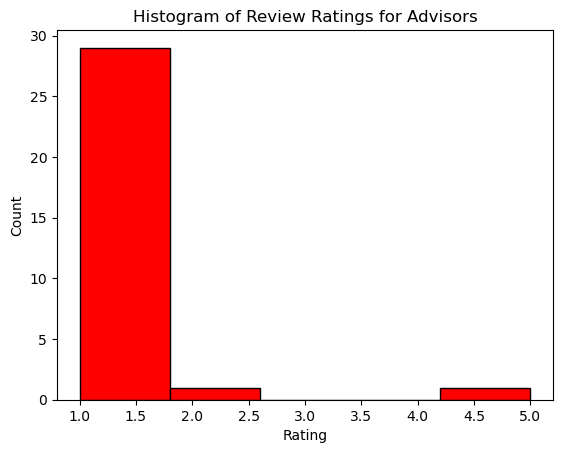

In [131]:
import matplotlib.pyplot as plt
# Want to see distribution of the rating for customers experience with advisors
plt.hist(advisor_reviews_df['Ratings'], bins=5, edgecolor='black',color='red')  # You can adjust the number of bins as needed
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Histogram of Review Ratings for Advisors')

In [113]:
advisor_reviews_df.groupby('Ratings').count().reset_index()

,Ratings,Reviews,Date
0,1,29,29
1,2,1,1
2,5,1,1


As observed from the histogram and and the table generated, most customers aren't satisfied with their experience with financial advisors. There are 31 reviews about financial advisors, 29 of them rated their experience as 1.

In [115]:
# Filter rows where the rating is 1 or 2 because we are only interested in areas of improvement
filtered_adv_rev_df = advisor_reviews_df[(advisor_reviews_df['Ratings'] == 1) | (advisor_reviews_df['Ratings'] == 2)]


# NLP
## Creating Custom List of Stop Words
From my experience working with NLP I know that some words that exist in nltk stop words do not exist in count vectorizer. So, I am creating a custome list to include stop words from both. Countvectorizer has more stopwords than nltk.

In [116]:
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string



In [117]:
nltk_stop_words = stopwords.words('english')

In [118]:
cv = CountVectorizer(stop_words='english')
cv_stop_words = cv.get_stop_words()

In [119]:
# Since the stop words from countvectorizer is a frozen set, I'll change it to normal set, so I can add more word to it
cv_stop_words = set(cv_stop_words)
for word in nltk_stop_words:
    if word not in cv_stop_words:
        cv_stop_words.add(word)

print(len(cv_stop_words))

378


## Tokenizer
Tokenizer tokenizes the reviews, removes stop words and lemmatizes them

In [120]:
import re

def my_tokenizer(document, lemmatization=True):
    '''
    Function for use in Vectorizer that tokenizes the document
    '''
    # all stop words are in lower case, I want to ensure that they don't get missed due to case sensitivity
    # hence putting document (each row of reviews) in lower case as well.
    document = document.lower()
    
    # pattern denoting a sequence of at least 2 alphanumeric characters, pattern excludes punctuations
    pattern = r"(?u)\b\w\w+\b"
    # tokenize - split by matching a pattern
    tokenized_document = re.findall(pattern, document)
    
    # remove stopwords before lemmatization
    tokenized_document = [word for word in tokenized_document if word not in cv_stop_words]
    
    # lemmatize
    if lemmatization==True:
        lemmatized_tokens_list = []
        for i in tokenized_document:
            token = WordNetLemmatizer().lemmatize(i)
            lemmatized_tokens_list.append(token)
        return lemmatized_tokens_list

    return tokenized_document

## Count vectorizer

In [121]:
# Initialise a CountVectorizer object
count_vectorizer = CountVectorizer(tokenizer=my_tokenizer, min_df=2,max_features=100)

# Fit the CountVectorizer object on X_train
count_vectorizer.fit(filtered_adv_rev_df['Reviews'])

# Transform X_train using the fitted CountVectorizer object
count_matrix_train = count_vectorizer.transform(filtered_adv_rev_df['Reviews'])

print(count_matrix_train.shape)

(30, 100)


C:\Users\Sundus Yawar\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Getting common words

In [122]:
import numpy as np
# sum all the rows for each feature
word_counts = pd.DataFrame(
        {"counts": np.array(count_matrix_train.sum(axis=0)).flatten()},
        index=count_vectorizer.get_feature_names_out()).sort_values("counts", ascending=False)

print('The most common words and their counts are:')
word_counts[:25]

The most common words and their counts are:


,counts
bank,52
account,46
advisor,41
time,37
branch,32
card,28
money,27
service,24
scotia,24
scotiabank,23


### Analysis
Based on the frequency count above, it seems that in relation to financial advisory customers have issues with the following:  
- Account Management based on the words
| Keyword   | Count |
|:---------:|:--------:|
| account   | 46       |
| card      | 28       |
| money     | 27       |
| financial | 22       |
| business  | 17       |
| close     | 16       |
| online    | 16       |
- Customer Service based on the words
| Keyword     | Count |
|:-----------:|:--------:|
| advisor     | 41       |
| service     | 24       |
| told        | 19       |
| customer    | 18       |
| called      | 15       |
| person      | 13       |
| experience  | 12       |
| manager     | 12       |
| phone       | 11       |
| appointment | 11       |
- Location based on the words
| Keyword | Count |
|:-------:|:--------:|
| bank    | 52       |
| branch  | 32       |
| scotia  | 24       |
| scotiabank  | 23       |
- Timeliness of Service issues based on the words
| Keyword | Count |
|:-------:|:--------:|
| time    | 36       |
| day     | 16       |
| month   | 16       |
| week    | 15       |
  
  
I'll need to filter the reviews by these key words to see what exactly were their concerns

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

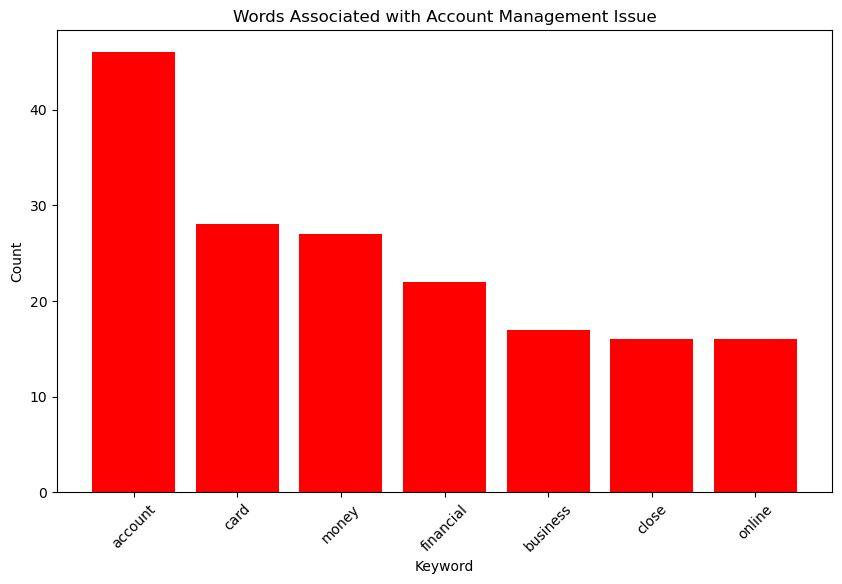

In [127]:
# account management issues
data = {
    'Keyword': ['account', 'card', 'money', 'financial', 'business', 'close', 'online'],
    'Count': [46, 28, 27, 22, 17, 16, 16]
}

account_management_df = pd.DataFrame(data)

# Create a bar chart with red bars
plt.figure(figsize=(10, 6))
bars = plt.bar(account_management_df['Keyword'], account_management_df['Count'], color='red')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.title('Words Associated with Account Management Issue')
plt.xticks(rotation=45)

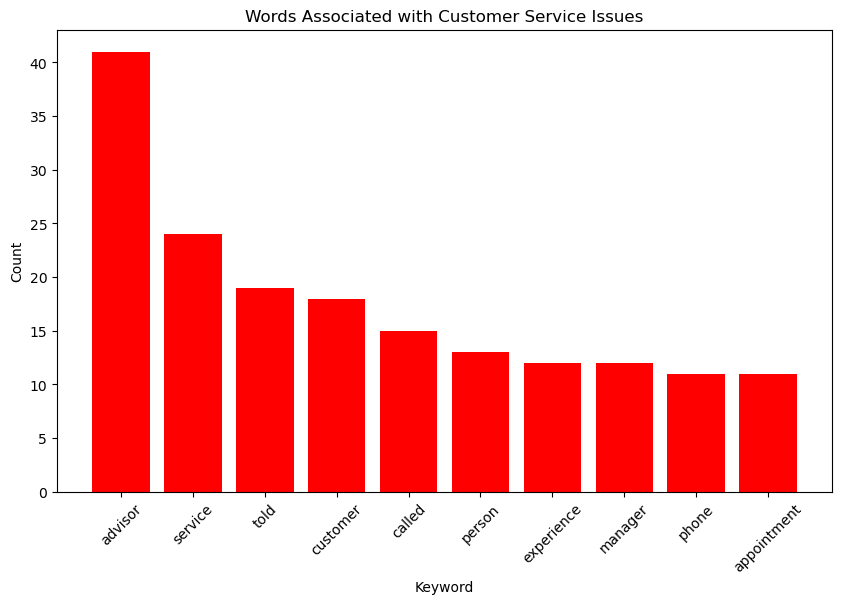

In [132]:
# customer service issues
data = {
    'Keyword': ['advisor', 'service', 'told', 'customer', 'called', 'person','experience', 'manager', 'phone', 'appointment'],
    'Count': [41, 24, 19, 18, 15, 13, 12, 12, 11, 11]
}

customer_service_df = pd.DataFrame(data)
# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(customer_service_df['Keyword'], customer_service_df['Count'], color='red')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.title('Words Associated with Customer Service Issues')
plt.xticks(rotation=45)
plt.show()


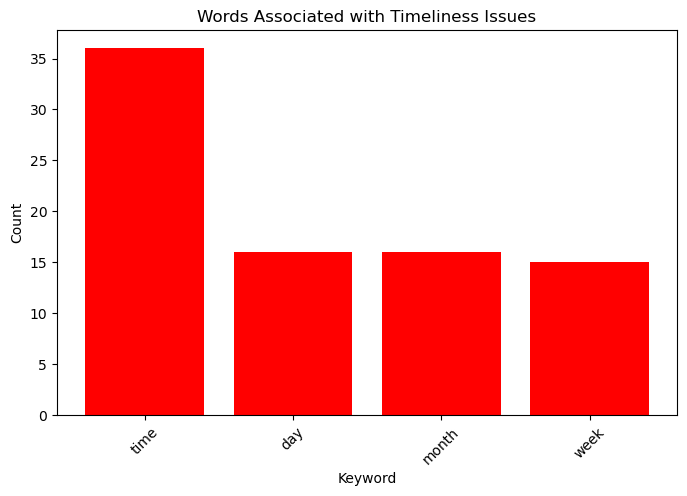

In [129]:
# timelineness
data = {
    'Keyword': ['time', 'day', 'month', 'week'],
    'Count': [36, 16, 16, 15]
}
timeliness_df = pd.DataFrame(data)

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(timeliness_df['Keyword'], timeliness_df['Count'], color='red')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.title('Words Associated with Timeliness Issues')
plt.xticks(rotation=45)
plt.show()

#### Understanding Account Management Issues


In [133]:
a_m_i_keywords = ["account", "card", "money", "financial", "business", "close", "online"]

a_m_i_df = filtered_adv_rev_df[filtered_adv_rev_df['Reviews'].str.contains('|'.join(a_m_i_keywords), case=False)]

In [134]:
a_m_i_df.shape

(28, 3)

In [136]:
a_m_i_rev_list = a_m_i_df['Reviews'].to_list()
a_m_i_date_list = a_m_i_df['Date'].to_list()
for i in range(len(a_m_i_rev_list)):
    print("=========\n\n=====",a_m_i_date_list[i],"\n >>>",a_m_i_rev_list[i])


===== 2023-09-30 00:00:00 
 >>> Would give 0 star if I could. Financial advisor didn’t do her job. So I was stuck wondering why my appointment with a notary was canceled . Took several emails and phone calls to get an answer after two weeks! One of the advisors told me with a fed-up tone that he was very busy.. and I should write him an email. I wrote him two emails before getting him on the phone. Then the branch director took matters in her own hands but…more delays! Mortgage Documents supposed to be issued and sent to me within a day showed up 3 days later after several mails and voice messages. And when I thought it would be a bit smoother now .. spoiler no! More delays and no explanation. What should have been taken a week isn’t done after a month. Worst experience ever. Customer service is a big 0!! Don’t go there. Avoid at all costs.

===== 2023-08-24 00:00:00 
 >>> Bloody aweful, advice so bad even another scotiabank advisor said it was wrong and I would be paying excess tax. 

- Customers aren't getting documents like Mortgage documents in a timely manner(should've gotten within a day based on discussion but received them 3 days later after following up several times)
    - Solution: Document upload within the app for timely retrieval but based on my research Scotiabank has a feature called e-Home-the online mortgage hub but it seems like the access to it is not intuitive. So would be great to add it to the app. I also spoke on call with financial advisor 

- customer had an issue with excess tax on a money transfer tried to discuss with a financial advisors then complained to branch manager which was ignored, 28 days went by with 0 solution to the problem
    - Scotiabank should create an FAQ on money transfer option that leads to less tax deductions so customers can have better experience and don't have to deal with discrepancies between advices received.  
       

- customer wasn't able to open high interest savings account online without hassle, customer tried to open it in-person and customer was charged a fee for not having min balance of 5k CDN. Booked appointment with an advisor based on teller's advice, issue escalated to maanger who accused client for not listening to the teller. **customer closed account**
    - Scotiabank does allow opening the HISA account online for both current and new users based on my research. I suppose the issue was encountered because the client card wasn't delivered to the user. Perhaps what Scotiabank can do is to send client message through app about their client card, so tehy can access services even when the card is not physically available to them.

- customer received contradictory advice form several customer service providers at scotiabank about taking money from RESP to pay for their child's tuition. customer was required to make appointment with financial advisors to withdraw money from RESP but didn't receive any advice from them upon request. The customer financial advisor didn't show up to appointment and another advisor stepped in, and although they were nice in guiding the money wasn't transfered causing the customer to get behind in payments.
    - Scotiabank should create an FAQ on money withdrawal from RESP so customers can have better experience and don't have to deal with discrepancies between advices received.
    - They should also eliminate the process of having to see an advisor for every withdrawal. Perhaps they can require this for the first withdrawal and set a threshold and let the user transfer money between account with ease. If the threshold is exceeded then require the customer to book an appointment with a advisor.

- customer sold major asset to reduce monthly mortgage payment as adviced by an advisor who said doing so will lower their monthly mortgage by $200-$300. The advisor who provided this advice was no longer working with Scotiabank upon their next appointment and had to deal with a new advisor who was new to the role. The way the new advisor dealt with it in a way that reduced only the payment term resulting in higher monthly mortgage payment.
    - Solution: To ensure customers have better experience advisors should make a note in the system for the advice they have given to the customer and Scotiabank should have a guide for advisors on how to perform certain actions. So, even if anohter advisor takes over the customer can receive the best service and have their issue resolved.
    
- New customer was able to open savings account online but had to see an advisor to open checking account and encountered issues with that too and finally decided to close accounts but had trouble with that too. As the person was required to see an advisor to withdraw 25cents before closing the account. The customer reported having cards that went missing due to which they needed to created checking account on an urgent basis. Customer also had issue with 2FA.
    - I am not sure how the client managed to open the savings account but had trouble with checking account. Seems like client only had credit card because client card would mean the client has checking account. We can dismiss this one as an anomaly.  
      
- current customer's interac transfer to SO got blocked without explanation, they had done this before without problems. They spoke with multiple advisors, and were sent on a wild goose chase to get an answer and had long wait times for a number they were finally suggested. The customer had to go in person to withdraw the money to give to SO and due to this issue and processing times the customer closed account
    - we'll need to see what may have resulted in the block, cant really offer a solution until further investigation   
      
- customer got overcharged something visited the bank and was told to meet with a financial advisor the financial advisors werenèt available. And booking an appointment on phone was difficult.
    - this review is from last year, I tried calling scotiabank to see if there is an automated option to book appointment via call. And on call I had to just press 4 for booking an appointment, then the machine said alternative ways to book the appointment like through website or app and then 1 minute later someone attended the call and asked me how they can help. 
      
- loyal customer's (customer for decades) financial advisor was fired, had to fill forms for new financial advisor, then weeks later received a mail for missing estate info but it didnt specify what info is missing, made a call to book an appointment and had to wait for hour and there is no call back feature, the client is old but tech savy as they compare it with TD which has online booking the appointment feature to see an advisor. The customer also discussed having to answer a bunch of security questions just to book an appointment.

# Research on Exisitng Product and Customer Reviews
- I noticed that the solution we came up with is already implemented. So, I looked into potential issues with the current system to make recommendations on how to enhance the user expereince with financial advisors. 
    - I tried booking the appointment as new client of scotiabank using this website later asked group member to try it from app to see if the issue I found persists: https://www.scotiabank.com/ca/en/personal/investing/financial-advisor.html
        - **These are my findings:*
            - Based on reviews I found that people didn't get the right fit for advisors.
            - Based on my experiement with the website it made sense because when I tried booking I was asked a few questions to match me with a advisor who has expereince in my area of need. It then asked me to select location and time for availability. It showed me the advisor picked for me at the end.
            - I also tried to reschedule the appointment but there was no option for it, I had to cancel and then refill the form
            - **To confirm my findings I asked my group member Emily who is Scotiabank user to fill the same form for booking appointment but with mobile app. She faced the same issues.**
            - **I also found in reviews that people had issues with booking appointments, so I called Scotiabank Etobicoke location and asked to speak with an advisor** I explained to the advisor that it is for this hackathon. And that I find it strange that majority of the issues are complaining about issues with booking appointments when we have the service to match advisors and even can book with automated phone call option. He explained that the issue is that people don't have a choice when it booking from the website. And if they have found a preferred advisor to work with the website doesn't allow that it randomly books them with any advisor and so they have to call to book an appointment with the specified advisor.
        - **Solution:** based on my initial assessment I suggested we have the option to pick our advisor and have the option to read their description. The group built onto this and suggested chat now feature with each advisor before booking. 
        - **Solution:** After speaking to the advisor I acquired better understanding about the review, and suggested we add the feature in future that allows user to make a advisor favourite for subcateogry of financial advisory service and next time be able to view their availability to book online
        
- **Issues I found strange in analysis and discussed with the advisor over call for clarity**
    - So, in reviews users mentioned delays with mortgage documents, so I was researching and found "e-home online mortgage hub" service online. So, I asked the advisor if documents are uploaded on it and what kind of things are available on it. 
        - Advisor mentioned that it is mainly for mortgage pre-approval related things. 
        - Advisor also mentioned that the original documents are the documents that are usually mailed and it is just 1 document so it doesn't matter as such to make it online. However, users do have access to documents like annual mortgage statements. I also inquired about what could be the issue in terms of calls when users speak about it. He mentioned that the only times the user call a lot in relation to mortgages is when they need info about principal balance and interest deducted because user only see the total amount deducted from their account.
    - Another thing I noticed from my review was that people reported that they had to make in person appointment with financial advisor to open the savings and checking account. I found this strange because I can see on Scotia bank website that it allows u to open an account. So I asked the same person, he said he doesnt deal with it in this role but when he used to (he has been with Scotiabnk for 2 years) ppl were able to open the account online but they had to come in person to very and activate the account. So I see an opportunity here to make this process online (verifying and activating by having the user to upload driver's license or passport online and a person can approve it online).
    - And I also asked him that people reported difficulty in booking appointment with finacial advisors but i see on website that it matches them to the financial advisor based on location and availability. So, he said yes that's right but the only prob here is that they dont have the preference say if they were working with someone else and prefer that person they can't choose. And they have to call to make the appointment with the same person. So, I mentioned how we added the option to select advisor by chatting and he liked that. But what we have is for new appointments, so something else we can add is ability to add favorite financial advisor for ur subcategory of wealth management so next time you need to book you can view their availability and book the appointment with them online.


# Summary for Vision (Next Steps)
The major issues based on the analysis of reviews and further look at the reviews based on filtering are as follows:
- Discrepancy between advices received from the financial advisors (advisors had major count and most reviews suggested this)
    - Solution: Collaboratively build internal FAQ for dealing with complex issues so all advisors are on the same page
- New advisors taking over older ones upon their leave, leading to issues with Account Management (2 major examples of this are customer sold major asset to reduce monthly mortgage payments but new one reduce payment term, and another is estate asset mishandled by the new advisor that took over the customer's decades-long advisor)
    - Solution: When old advisors leave they should do documentation about what they suggested the client to do and how they planned on handling it. So, whoever takes over is in the loop and is able to provide continued quality service.
- Not receiving documents in a timely manner and long wait times on call
    - Software solution: Secure document upload and download for timely access to documents
    - Software Solution: Having info about interest deducted and principal balance available on website (spoke to mortgage advisor on call and discussed one of the reviews and e-home online mortgage hub, he mentioned customers mostly call about this info)
- User experiencing challenges to book with preferred advisor user has expereince working with. (User has to make a phone call for this and goes through a series of security questions to answer just to book an appointment)
    - Software Solution: allow user to save preferred advisor as favourite and view their availability to book an appointment